# DQN and DDQN
### Implements DQN and DDQN on CartPole environment (or any other environment that doesn’t require frame stacking)

In [1]:
!pip install gymnasium
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import time


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# NN

In [2]:
class NeuralNetwork(nn.Module):
    """
    Neural Network, subclass of torch.nn.Module
    """
    def __init__(self, n_actions, state_size):
        """
        Initializes neural network
        """
        super().__init__()
        self.linear_relu_stack = nn.Sequential(nn.Linear(state_size, state_size * 2),
                                               nn.ReLU(),
                                               nn.Linear(state_size * 2, n_actions),
                                              )

    def forward(self, x):
        """
        Performs forward pass in network

        :param x: network input
        :return:  network prediction
        """
        y = self.linear_relu_stack(x)
        return y


# Dataset and DataLoader

In [3]:
class ExperiencesDataset(Dataset):
    """
    Dataset used to train the online network, subclass of torch.utils.data.dataset
    """
    def __init__(self, agent, memory_subset):
        """
        Initializes dataset

        :param agent:         agent thats beeing trained
        :param memory_subset: experiences sampled randomly from agent.replay_memory
        :return:              None
        """
        #labels and inputs lists
        self.inputs = []
        self.labels = []

        #loop experiences
        for experience in memory_subset:

            #get network input and corresponding label
            input_, label = agent.algorithm(experience)

            #append input and label to corresponding lists
            self.labels.append(label)
            self.inputs.append(input_)

    def __len__(self):
        """
        Gets length of dataset

        :return: length of dataset
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Fetches network input and correspodning label

        :param idx: list index for network input and corresponding label
        :return:    network input and corresponding label
        """
        input_, label = self.inputs[idx], self.labels[idx]
        return input_, label

# Agent

In [4]:
class Agent():
    """
    Deep Q-learning agent
    """
    def __init__(self, n_actions, state_size, algorithm, copy_frequency=100, batch_size=320, device='cpu', epsilon_end=0.05, epsilon_start=1,
                 gamma=0.99, loss_fn='MSELoss', learning_rate=0.00025, memory_capacity=10000, mini_batch_size=32,
                 optimizer='RMSprop'):

        """
        Initializes agent

        :param algorithm:        algorithm used for creating labels in training. Options: 'DQN', 'DDQN'
        :param batch_size:       size of batches used in training
        :param copy_frequency:   frequency of copying online network to offline network
        :param device:           device on which training is performed
        :param epsilon_end:      final probability of choosing random action
        :param epsilon_start:    initial probability of choosing random action
        :param gamma:            discount factor used for target q-value
        :param loss_fn:          loss function used for training self.NN_target. Options: all loss functions in torch.nn
        :param memory_capacity:  capacity of memory
        :param mini_batch_size:  size of mini batches in training
        :param n_actions:        number of actions available in environment
        :param optimizer:        optimizer used for training self.NN_pred. Options: all optimizers in torch.optim
        :param state_size:       size of state (flattened)
        :return:                 None
        """
        self.actions = range(n_actions)
        self.algorithm = getattr(self, algorithm)
        self.batch_size = batch_size
        self.copy_frequency = copy_frequency
        self.device = device
        self.NN_pred = NeuralNetwork(n_actions, state_size).to(device)
        self.NN_target = copy.deepcopy(self.NN_pred)
        self.epsilon_end = epsilon_end
        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start
        self.gamma = gamma
        self.loss_fn = getattr(nn, loss_fn)()
        self.mini_batch_size = mini_batch_size
        self.memory_capacity = memory_capacity
        self.optimizer = getattr(torch.optim, optimizer)(self.NN_pred.parameters(), lr = learning_rate)
        self.replay_memory = []


    def save_experience(self, state, action, reward, next_state, terminated, truncated):
        """
        Saves experience in agents memory

        :param state:      agents state in environment
        :param action:     action performed by agent
        :param reward:     reward recieved by performing action in state
        :param next_state: next state reached by performing action in state
        :param terminated: true if next_state is a terminating state, otherwise false
        :param truncated:  true if episode has been truncated, otherwise false
        :return:           None
        """
        #removes oldest experience from memory
        if len(self.replay_memory) == self.memory_capacity:
            self.replay_memory.pop(0)

        #adds new experience to memory
        self.replay_memory.append([state, action, reward, next_state, terminated, truncated])

    def select_action(self, state):
        """
        Selects action from actions

        :param state: current state
        :return:      selected action
        """
        #selects random action with probability = epsilon
        if random.random() < self.epsilon:
            action = random.choice(self.actions)

        #selects maximizing action with probability 1-epsilon
        else:
            with torch.no_grad():
                action = torch.argmax(self.NN_pred(state)).item()

        return action

    def train(self):
        """
        Trains self.NN_pred

        :return: None
        """
        #select random memory subset and create dataset and dataloader
        memory_subset = random.choices(self.replay_memory, k = self.batch_size)
        training_data = ExperiencesDataset(self, memory_subset)
        train_dataloader = DataLoader(training_data, batch_size= self.mini_batch_size, shuffle=False)

        #loop batches in dataloader
        for X, Y in train_dataloader:

            #make predictions
            pred = self.NN_pred(X)

            #calculate loss
            loss = self.loss_fn(pred, Y)

            #backward propagation
            loss.backward()

            #update parameters
            self.optimizer.step()

            #reset gradients to zero
            self.optimizer.zero_grad()

    def copy(self):
        """
        Copies prediction network to target network

        :return: None
        """
        self.NN_target = copy.deepcopy(self.NN_pred)

    def calc_epsilon(self, episode, n_episodes):
        """
        Decays epsilon

        :param episode:    current episode number
        :param n_episodes: total number of episodes
        :return:           None
        """
        #calculates new epsilon by performing linear interpolation
        self.epsilon = self.epsilon_start - (((self.epsilon_start - self.epsilon_end) / n_episodes) * episode)

    def DQN(self, experience):
        """
        Fetches network input and calculates corresponding label
        in accordance with DQN-algorithm

        :param experience: one agent experience, type: [state, action, reward, next_state, terminated, truncated]
        :return:           network input and corresponding label
        """
        #unwrap experience
        state, action, reward, next_state, terminated, truncated = experience

        #calculate Q-value label
        with torch.no_grad():
            label = self.NN_pred(state)
            if truncated:
                label[action] = reward
            elif terminated:
                label[action] = 0
            else:
                label[action] = reward + self.gamma * torch.max(self.NN_target(next_state))

        return state, label

    def DDQN(self, experience):
        """
        Fetches network input and calculates corresponding label
        in accordance with Double DQN-algorithm

        :param experience: one agent experience, type: [state, action, reward, next_state, terminated, truncated]
        :return:           network input and corresponding label
        """
        #unwrap experience
        state, performed_action, reward, next_state, terminated, truncated = experience

        #calculate Q-value label
        with torch.no_grad():
            label = self.NN_pred(state)
            if truncated:
                label[performed_action] = reward
            elif terminated:
                label[performed_action] = 0
            else:
                maximizing_action = torch.argmax(label)
                maximizing_action_value = self.NN_target(next_state)[maximizing_action]
                label[performed_action] = reward + self.gamma * maximizing_action_value

        return state, label


# Main
### Change algorithm by changing the 'algorithm' variable. 
### Cell can be stopped during run time and still show results.



In [5]:
 #results, also plot average, and avarge over episodes
 #for new environment; stack states, CNN

#create and preprocess environment
env = gym.make('CartPole-v1', render_mode="rgb_array", max_episode_steps = 475)
env = FlattenObservation(env)
state, info = env.reset()

#settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_run_time = 60*90
n_episodes = 500
algorithm = 'DDQN' #options: DQN and DDQN

#initialize agent
agent = Agent(algorithm = algorithm,
              device = device,
              n_actions = env.action_space.n,
              state_size = state.size)

#load agents online network with previously trained parameters and copy to target network
#agent.NN_pred.load_state_dict(torch.load('model.pth'))
#agent.NN_target = copy.deepcopy(agent.NN_pred)

#for-loop: each loop initializes, simulates and logs one episode
episodes_rewards = []
average_rewards = []
step_counter = 0
start_time = time.time()
for episode in range(1, n_episodes):

    #initialize episode
    episode_reward = 0
    state, info = env.reset()
    state = torch.from_numpy(state).to(device)
    terminated = False
    truncated = False

    #while-loop: simulates one episodes, loops until agent reaches terminating state or environment is truncated
    while not terminated and not truncated:

        #select action
        action = agent.select_action(state)

        #perform one step and save experience
        next_state, reward, terminated, truncated, info = env.step(action)
        step_counter += 1
        episode_reward += reward
        next_state = torch.from_numpy(next_state).to(device)
        agent.save_experience(state, action, reward, next_state, terminated, truncated)

        #train online network
        if step_counter > agent.batch_size:
            agent.train()

        #copy online network to target network
        if step_counter % agent.copy_frequency == 0:
            agent.copy()

        #next state --> current state
        state = next_state

    #save episode reward
    episodes_rewards.append(episode_reward)
    average = sum(episodes_rewards)/len(episodes_rewards)
    average_rewards.append(average)
    
    #calculate elapsed time
    elapsed_time = time.time() - start_time

    print(f'Episode: {episode}, Episode reward: {episode_reward}, Elapsed time: {elapsed_time/60} minutes, Epsilon {agent.epsilon}')

    #stop training if maximum running time is surpassed
    if elapsed_time > max_run_time:
        print(f'Breaking after {elapsed_time/60} minutes. Performed {len(episodes_rewards_list)} episodes, total steps: {step_counter}')
        break

    #decay epsilon
    agent.calc_epsilon(episode, n_episodes)

#save the online networks parameters
torch.save(agent.NN_pred.state_dict(), 'model.pth')

#close environment
env.close()


Episode: 1, Episode reward: 36.0, Elapsed time: 1.6701221466064452e-05 minutes, Epsilon 1
Episode: 2, Episode reward: 16.0, Elapsed time: 3.158251444498698e-05 minutes, Epsilon 0.9981
Episode: 3, Episode reward: 10.0, Elapsed time: 3.158251444498698e-05 minutes, Epsilon 0.9962
Episode: 4, Episode reward: 21.0, Elapsed time: 4.841089248657227e-05 minutes, Epsilon 0.9943
Episode: 5, Episode reward: 31.0, Elapsed time: 6.510019302368164e-05 minutes, Epsilon 0.9924
Episode: 6, Episode reward: 19.0, Elapsed time: 8.173386255900065e-05 minutes, Epsilon 0.9905
Episode: 7, Episode reward: 33.0, Elapsed time: 9.845097859700521e-05 minutes, Epsilon 0.9886
Episode: 8, Episode reward: 17.0, Elapsed time: 0.00011525551478068034 minutes, Epsilon 0.9867
Episode: 9, Episode reward: 16.0, Elapsed time: 0.00013175010681152344 minutes, Epsilon 0.9848
Episode: 10, Episode reward: 32.0, Elapsed time: 0.000271145502726237 minutes, Epsilon 0.9829
Episode: 11, Episode reward: 45.0, Elapsed time: 0.00030392805

Episode: 90, Episode reward: 58.0, Elapsed time: 2.3742159088452657 minutes, Epsilon 0.8309
Episode: 91, Episode reward: 14.0, Elapsed time: 2.3931324044863382 minutes, Epsilon 0.829
Episode: 92, Episode reward: 76.0, Elapsed time: 2.483186900615692 minutes, Epsilon 0.8271
Episode: 93, Episode reward: 15.0, Elapsed time: 2.501007076104482 minutes, Epsilon 0.8251999999999999
Episode: 94, Episode reward: 17.0, Elapsed time: 2.521032663186391 minutes, Epsilon 0.8233
Episode: 95, Episode reward: 25.0, Elapsed time: 2.5502684513727822 minutes, Epsilon 0.8214
Episode: 96, Episode reward: 22.0, Elapsed time: 2.5758246382077536 minutes, Epsilon 0.8195
Episode: 97, Episode reward: 47.0, Elapsed time: 2.6311230778694155 minutes, Epsilon 0.8176
Episode: 98, Episode reward: 19.0, Elapsed time: 2.6534852743148805 minutes, Epsilon 0.8157
Episode: 99, Episode reward: 13.0, Elapsed time: 2.6688018600145975 minutes, Epsilon 0.8138
Episode: 100, Episode reward: 59.0, Elapsed time: 2.7375564495722453 min

Episode: 178, Episode reward: 47.0, Elapsed time: 6.504415627320608 minutes, Epsilon 0.6637
Episode: 179, Episode reward: 53.0, Elapsed time: 6.6028060952822365 minutes, Epsilon 0.6617999999999999
Episode: 180, Episode reward: 21.0, Elapsed time: 6.641251305739085 minutes, Epsilon 0.6598999999999999
Episode: 181, Episode reward: 60.0, Elapsed time: 6.744365588823954 minutes, Epsilon 0.6579999999999999
Episode: 182, Episode reward: 144.0, Elapsed time: 7.003186766306559 minutes, Epsilon 0.6561
Episode: 183, Episode reward: 53.0, Elapsed time: 7.098926381270091 minutes, Epsilon 0.6542
Episode: 184, Episode reward: 45.0, Elapsed time: 7.175337541103363 minutes, Epsilon 0.6523
Episode: 185, Episode reward: 20.0, Elapsed time: 7.213793512185415 minutes, Epsilon 0.6504
Episode: 186, Episode reward: 10.0, Elapsed time: 7.23180121978124 minutes, Epsilon 0.6485000000000001
Episode: 187, Episode reward: 58.0, Elapsed time: 7.3450200200080875 minutes, Epsilon 0.6466000000000001
Episode: 188, Epis

Episode: 264, Episode reward: 103.0, Elapsed time: 16.067035885651908 minutes, Epsilon 0.5003
Episode: 265, Episode reward: 199.0, Elapsed time: 16.334607048829398 minutes, Epsilon 0.49839999999999995
Episode: 266, Episode reward: 197.0, Elapsed time: 16.597690172990163 minutes, Epsilon 0.49650000000000005
Episode: 267, Episode reward: 246.0, Elapsed time: 16.927860856056213 minutes, Epsilon 0.49460000000000004
Episode: 268, Episode reward: 415.0, Elapsed time: 17.48865399360657 minutes, Epsilon 0.4927
Episode: 269, Episode reward: 263.0, Elapsed time: 17.843604203065237 minutes, Epsilon 0.4908
Episode: 270, Episode reward: 329.0, Elapsed time: 18.283432006835938 minutes, Epsilon 0.4889
Episode: 271, Episode reward: 125.0, Elapsed time: 18.450606230894724 minutes, Epsilon 0.487
Episode: 272, Episode reward: 415.0, Elapsed time: 19.034395519892374 minutes, Epsilon 0.4851
Episode: 273, Episode reward: 102.0, Elapsed time: 19.218740753332774 minutes, Epsilon 0.48319999999999996
Episode: 2

Episode: 346, Episode reward: 281.0, Elapsed time: 37.15765565633774 minutes, Epsilon 0.34450000000000003
Episode: 347, Episode reward: 475.0, Elapsed time: 37.62981239159902 minutes, Epsilon 0.3426
Episode: 348, Episode reward: 475.0, Elapsed time: 38.10224097172419 minutes, Epsilon 0.3407
Episode: 349, Episode reward: 293.0, Elapsed time: 38.394745361804965 minutes, Epsilon 0.3388
Episode: 350, Episode reward: 294.0, Elapsed time: 38.687944261233014 minutes, Epsilon 0.3369
Episode: 351, Episode reward: 298.0, Elapsed time: 38.983802390098575 minutes, Epsilon 0.33499999999999996
Episode: 352, Episode reward: 221.0, Elapsed time: 39.20240429242452 minutes, Epsilon 0.33309999999999995
Episode: 353, Episode reward: 204.0, Elapsed time: 39.407935845851895 minutes, Epsilon 0.33120000000000005
Episode: 354, Episode reward: 214.0, Elapsed time: 39.620498502254485 minutes, Epsilon 0.32930000000000004
Episode: 355, Episode reward: 171.0, Elapsed time: 39.7899648865064 minutes, Epsilon 0.3274
E

Episode: 428, Episode reward: 475.0, Elapsed time: 58.26215262413025 minutes, Epsilon 0.18869999999999998
Episode: 429, Episode reward: 475.0, Elapsed time: 58.73353768587113 minutes, Epsilon 0.18679999999999997
Episode: 430, Episode reward: 475.0, Elapsed time: 59.39677335818609 minutes, Epsilon 0.18489999999999995
Episode: 431, Episode reward: 475.0, Elapsed time: 60.05851257244746 minutes, Epsilon 0.18300000000000005
Episode: 432, Episode reward: 475.0, Elapsed time: 60.79817719856898 minutes, Epsilon 0.18110000000000004
Episode: 433, Episode reward: 475.0, Elapsed time: 61.46475914319356 minutes, Epsilon 0.17920000000000003
Episode: 434, Episode reward: 475.0, Elapsed time: 62.14958671331406 minutes, Epsilon 0.1773
Episode: 435, Episode reward: 475.0, Elapsed time: 62.81350075006485 minutes, Epsilon 0.1754
Episode: 436, Episode reward: 475.0, Elapsed time: 63.47507603168488 minutes, Epsilon 0.1735
Episode: 437, Episode reward: 475.0, Elapsed time: 64.13497395515442 minutes, Epsilon

# Results

Episodes: 499, Total frames: 71850


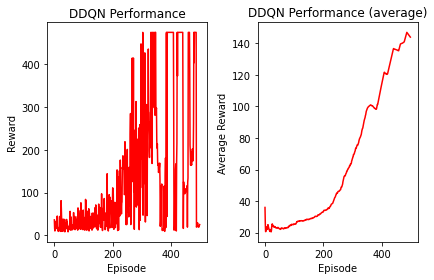

In [7]:
print(f'Episodes: {len(episodes_rewards)}, Total frames: {step_counter}')

#plot 1
fig, ax = plt.subplots(1,2)
ax[0].set_title(f'{algorithm} Performance')
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Reward")
x = range(len(episodes_rewards))
y = episodes_rewards
ax[0].plot(x, y, color ="red")

#plot 2
ax[1].set_title(f'{algorithm} Performance (average)')
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Average Reward")
x = range(len(average_rewards))
y = average_rewards
ax[1].plot(x, y, color ="red")

fig.tight_layout()
plt.show()